<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ImageGeneration/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN


## Introduction

This practical session explains how to use and train DCGANs as generative models. Specifically, we will use DCGANs to generate images as MNIST digits.

**References:**

The main code for this lab session is taken from [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).


**Authors of this adaptation:**
* Lucía Bouza
* Bruno Galerne

## Underlying principle

### GAN

GANs, proposed in [Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D.,
Ozair, S., Courville, A. y Bengio, Y. (2014). Generative Adversarial Networks. https://doi.org/10.48550/arxiv.1406.2661](https://arxiv.org/abs/1406.2661) is a framework for estimating generative models.

The idea is to train simultaneously two models: A generator model that captures the data distribution, and a discriminator model that estimates the probability that a sample came from the training dataset instead of being drawn by the generator. In other words, the generator is trained to learn to create images that follow the distribution of the real images to trick the discriminator. The discriminator is trained to learn to determine if the images it receives are real or fake.

Formalizing, let $x$ be data representing an image. $D(x)$ represents the probability that $x$ came from the $p_{data}$ rather than the generator’s distribution $p_g$. Let $z$ be a latent space vector sampled from a standard normal distribution $p_z$. $G(z)$ represents the generator function which maps the latent vector $z$ to data-space.

We train $D$ to maximize the probability of assigning the correct label to both training examples and samples from $G$. At the same time, we train $G$ to minimize $\log(1 − D(G(z)))$:

\begin{align}\underset{G}{\text{min }} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[\log(D(x))\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[\log(1-D(G(z)))\big]\end{align}


### DCGAN

DCGANs is a framework like GANs, but uses CNNs in the discriminator and generator. The idea is to be able to use all the virtues that CNN networks have in computer vision in supervised learning, in unsupervised learning.

This extension was proposed in [Radford, Alec et al. “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.” CoRR abs/1511.06434 (2016): n. pag.](https://arxiv.org/pdf/1511.06434.pdf). In this work, the authors also evaluate a set of restrictions on the architectural topology of DCGANs and certain conditions to make a stable training such as the configuration of optimizers, loss functions and weight initializations.


## Importing packages

Below is a list of packages needed to implement DCGANs. PyTorch version used to run this notebook is **1.11.0+cu113** (to check the installed version, use `torch.__version__`)

* `torch` (indispensable packages for neural networks with PyTorch)
* `nn` (to define network)
* `MNIST`, `transforms` and `data` (to work with the MNIST dataset)
* `matplotlib.pyplot` (to display images)
* `os` (to interact with the operating system)
* `optim` (efficient gradient descent)
* `vutils` and `numpy` (used here to display images)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np

## Set a device

Next, we need to choose which device to run the algorithm on. We can use `torch.cuda.is_available()` to detect if there is a GPU available. Next, we set the `torch.device`. The `.to(device)` method is used to move tensors or modules to a desired device, we will use it in next sections.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

Device is cuda
Fri Jun 16 16:10:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                         

## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [ ]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

## Generator and Discriminator Models

The architecture guidelines for stable DCGANs mentioned in the [paper](https://arxiv.org/pdf/1511.06434.pdf) are:
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator). See this [github site](https://github.com/vdumoulin/conv_arithmetic) to view animations of all kind of convolutions.
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

**The generator** maps $z$ (a latent space vector sampled from a standard normal distribution) to data-space (in our case images the MNIST images having size 1x28x28).

In practice, this is accomplished through a series of Conv2DTranspose (Upsampling) layers each paired with a 2D batch norm layer and a Relu activation. We upsample the image three times so as to reach the desired image size. The output of the generator is fed through a tanh function to return it to the input data range of [-1,1].

**The discriminator** outputs the probability that the input (an image) came from real MNIST images rather than the generator.

In practice, this is accomplished through a series of Conv2d, 2D batch norm, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function.

In [ ]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [ ]:
# check sizes:
import torchsummary

# Create some generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

torchsummary.summary(netG, input_size=(nz,1,1))
torchsummary.summary(netD, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]              64
             Tanh-14            [-1, 1,

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma^2=0.02$. We implement `weights_init` function to reinitialize the weights.

In [ ]:
# Code from DCGANs tutorial https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

## Display functions:

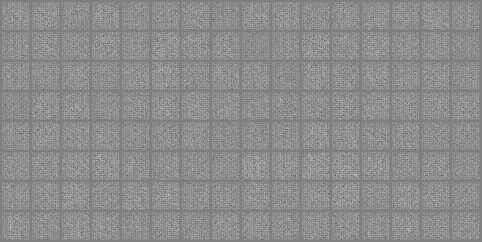

Image size (h x w):  242 x 482


In [ ]:
def imshow(img):
    img = img*0.5 + 0.5     # unnormalize
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return(pil_img)

def show_netG(z=None, nz=100, netG=netG):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = netG(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

show_netG();

## GAN training code

In PyTorch,
the function `nn.BCEWithLogitsLoss` combines a `Sigmoid` layer and the `BCELoss`, that is,  for $(x,y)\in\mathbb{R}\times \{0,1\}$,
$$
\ell(x,y) =  -y \cdot \log \sigma(x)
        - (1 - y) \cdot \log (1 - \sigma(x))
$$
where $\sigma: \mathbb{R}\to (0,1)$ is the sigmoid function defined by
$$
\sigma(x) = \frac{e^x}{1+e^{x}} = \frac{1}{1+e^{-x}}.
$$
The sigmoid function plays the role of the `softmax` function for binary classification since it maps $\mathbb{R}\to (0,1)$ to produce the probability of being in the class $y=1$ (and then $1 - \sigma(x)$ is the probability of being in the class $y=0$).

In the course formula of the discriminator loss,
$$
      \max_{\theta_d}
      \underbrace{
        \sum_{x_{\text{real}} \in \mathcal{T}_{\text{real}}} \log D_{\theta_d}(x_{\text{real}})}_{
        \substack{
          \text{force predicted labels to be 1}\\
          \text{for real images}
        }
      }
      +
      \underbrace{
        \sum_{x_{\text{fake}} \in \mathcal{T}_{\text{fake}}} \log (1 - D_{\theta_d}(x_{\text{fake}}))}_{
        \substack{
          \text{force predicted labels to be 0}\\
          \text{for fake images}
        }}
$$
the sigmoid layer is implicitly included in $D_{\theta_d}$, but this will not be the case in the PyTorch implementation.
In short,
$$
D_{\theta_d}(x) = \sigma(\mathtt{netD}(x)).
$$

**Exercise**

Implement the following training algorithm in the ```train```function above, where $b$ is the batch size:


> For each batch of images $x_{\text{real}}$:
> > **1) Train discriminator:**
> > > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables
> > > Generate  $x_{\text{fake}} = \mathtt{netG}(z)$ a set $b$ fake images
> > > Compute the (opposite of the) loss to minimize for the discriminator using `nn.BCEWithLogitsLoss`
> > > Compute the gradient and do an optimizer step for the disciminator parameters

> > **2) Train the generator:**
> > > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables
> > > Compute the loss to minimize
$$
      \underbrace{
        -
        \sum_{z \in \mathcal T_{\text{rand}}} \log D_{\theta_d}(G_{\theta_g}(z)))
      }_{
        \substack{
          \text{force the discriminator to think that}\\
          \text{our generated fake images are real (close to 1)}
        }
      }
$$
using `nn.BCEWithLogitsLoss`
Compute the gradient and do an optimizer step for the disciminator parameters

The ```train```functions also displays regularly the current losses and show generated images.

Train the networks for 5 epochs using batch size $b=128$.



In [ ]:
criterion = nn.BCEWithLogitsLoss()

# Labels to specify what part of the BCE equation to use
y_1 = torch.full((batch_size,), 1. , dtype=torch.float, device=device) # To select first part
y_0 = torch.full((batch_size,), 0. , dtype=torch.float, device=device) # To select second part

## Optimizers

We configure an optimizer for $D$ and another one for $G$. As specified in the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf), we use Adam optimizers with learning rate 0.0002 and Beta1 = 0.5 to run gradient descent on each network.

In [ ]:
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def train(train_loader, optimizerD, optimizerG, y_1, y_0, criterion, num_epochs, log_every, batch_size, nz, device, netG,netD, show_netG):
    zviz = torch.randn(batch_size,nz,1,1).to(device)
    for epoch in range(num_epochs):
        # For each batch in the train_loader
        for i, batch in enumerate(train_loader, 0):

            ############################
            # Batchs of real and fake images
            real = batch[0].to(device)
            fake = netG(torch.randn(batch_size, nz, 1, 1, device=device))

            ############################
            # Update D network
            netD.zero_grad()

            # Forward pass real batch. Calculate loss. Calculate gradients
            # INSERT YOUR CODE

            # Forward pass fake batch. Calculate loss. Calculate gradients
            # INSERT YOUR CODE

            # Compute error of D. Update D
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # Update G network
            netG.zero_grad()

            # Forward pass fake batch. Calculate loss. Calculate gradients
            # INSERT YOUR CODE

            # Update G
            optimizerG.step()

            ############################
            # Display training stats and visualize
            if i % log_every == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(train_loader), errD.item(), errG.item()))
                show_netG(z=zviz)

In [ ]:
train(train_loader, optimizerD, optimizerG, y_1, y_0, criterion, num_epochs = 5, log_every = 1000, batch_size = batch_size, nz = nz, device = device, netG = netG,netD = netD, show_netG = show_netG)

## Interpolation in latent space:

**Exercise:**

Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$ (using the `torch.linspace` function with 20 intermediate values).
Display all the images in a grid of height 10 and width 20 images.

Be carefull that DCGAN is designed to generate batches of images due the batch normalization. It is advised to use 128 latent codes and only display the first 10.


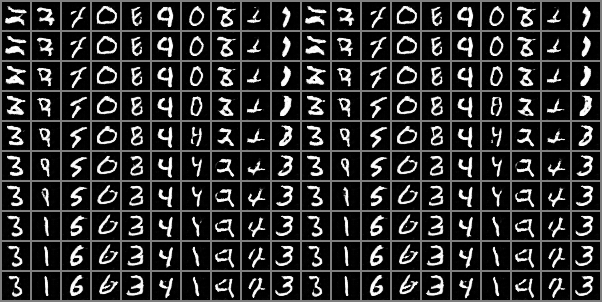

Image size (h x w):  302 x 602


In [ ]:
InterpolationInLatentSpace(batch_size, nz, device, netG, imshow)

To import the solutions, execute the following cell.









In [ ]:
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/Solutions/DCGAN.py")
from DCGAN import *